In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

### Causality ###
Our methods for comparing two samples have a powerful use in the analysis of randomized controlled experiments. Since the treatment and control groups are assigned randomly in such experiements, any differences in their outcomes can be compared to what would happen just due to the randomness in the assignment if the treatment had no effect at all. If the observed differences are more marked than what we would predict as purely due to chance, we will have evidence of *causation*. Because of the unbiased assignment of individuals to the treatment and control groups, differences in the outcomes of the two groups can be ascribed to the treatment.

The key to the analysis of randomized controlled experiments is understanding exactly how chance enters the picture. This helps us set up clear null and alternative hypotheses. Once that's done, we can simply use the methods of the previous section to complete the analysis.

Let's see how to do this in an example.

### Treating Chronic Back Pain: An RCT ###
Low-back pain in adults can be very persistent and hard to treat. Common methods run the gamut from corticosteroids to acupuncture. A [randomized controlled trial (RCT)](https://www.ncbi.nlm.nih.gov/pubmed/11376175) examined the effect of using Botulinum Toxin A as a treatment. Botulinum toxin is a neurotoxic protein that causes the disease botulism; [Wikipedia](https://en.wikipedia.org/wiki/Botulinum_toxin) says that botulinum "is the most acutely lethal toxin known." There are seven types of botulinum toxin. Botulinum Toxin A is one of the types that can cause disease in humans, but it is also used in medicine to treat various diseases involving the muscles. The RCT analyzed by Foster, Clapp, and Jabbari in 2001 examined it as a treatment for low back pain.

Thirty one patients with low-back pain were randomized into treatment and control groups, with 15 in treatment and 16 in control. The control group was given normal saline, and the trials were run double-blind so that neither doctors nor patients knew which group they were in.

Eight weeks after the start of the study, nine of the 15 in the treatment group and two of the 16 in the control group had pain relief (defined precisely by the researchers). These data are in the table `bta` and appear to show that the treatment has a clear benefit.

In [2]:
bta = Table.read_table('bta.csv')
bta

Group,Result
Control,1
Control,1
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0
Control,0


In [3]:
bta.group('Group', np.mean)

Group,Result mean
Control,0.125
Treatment,0.6


In the treatment group, 60% of the patients had pain relief, compared to only 12.5% in the control group. None of the patients suffered any side effects. 

So the indications are that botolinum toxin A did better than the saline. But the conclusion isn't yet a slam-dunk. The patients were assigned at random into the two groups, so perhaps the difference could just be due to chance?

To understand what this means, we have to consider the possibility that among the 31 people in the study, some were simply better able to recover than others, even without any help from the treatment. What if an unusually large proportion of them got assigned to the treatment group, just by chance? Then even if the treatment did nothing more than the saline in the control group, the results of the treatment group might look better than those of the control group. 

To account for this possibility, let's start by carefully setting up the chance model.

### Potential Outcomes ###
Before the patients are randomized into the two groups, our minds instinctively imagine two possible outcomes for each patient: the outcome that the patient would have if assigned to the treatment group, and the outcome that the same patient would have if assigned to the control group. These are called the two *potential outcomes* of the patient.

Thus there are 31 potential treatment outcomes and 31 potential control ouctomes. The question is about the distributions of these two sets of 31 outcomes each. Are they the same, or are they different?

We can't answer this just yet, because we don't get to see all 31 values in each group. We just get to see a randomly selected 16 of the potential control outcomes, and the treatment outcomes of *the remaining* 15 patients. 

Here is a good way to visualize the setting. Each patient has a two-sided ticket:

![Two-sided ticket](/images/causality1.png)

After the randomization, we get to see the right half of a randomly selected set of tickets, and the left half of the remaining group.

![Half-tickets](/images/causality2.png)

The table `observed_outcomes` collects the information about every patient's potential outcomes, leaving the unobserved half of each "ticket" blank.  (It's just another way of thinking about the `bta` table, carrying the same information.)

In [66]:
observed_outcomes = Table.read_table("observed_outcomes.csv")
observed_outcomes.show()

Group,Outcome if assigned treatment,Outcome if assigned control
Control,Unknown,1
Control,Unknown,1
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0
Control,Unknown,0


### A Test of Hypotheses ###
The question is whether the treatment does anything. In terms of the table `observed_outcomes`, the question is whether the distribution of the 31 "treatment" values in column 2 (including the unknown ones) is different from the distribution of the 31 "control" values in column 3 (again including the unknown ones).

**Null Hypothesis:** The distribution of all 31 potential "treatment" outcomes is the same as that of all 31 potential "control" outcomes. The treatment does nothing different from the control; the difference in the two samples is just due to chance.

**Alternative Hypotheses:** The distribution of 31 potential "treatment" outcomes is different from that of the 31 control outcomes. The treatment does something different from the control.

To test these hypotheses, notice that if the null hypothesis were true, then all assignments of the 31 observed outcomes to a group of 16 outcomes labeled "control" and the other 15 labeled "treatment" would be equally likely. So we can simply permute the values and see how different the distributions in the two groups are. Even more simply, since the data are numerical, we can just see how different the two means are. 

That's exactly what we did for A/B testing in the previous section. Sample A is now the control group and Sample B the treatment group. Our test statistic is the absolute difference between the two group means. 

Let's run our permutation test for the difference between means. There are only 31 observations, so we can run a large number of permutations without having to wait too long for the results.

In [11]:
def permutation_test_means(table, variable, classes, repetitions):
    
    """Test whether two numerical samples 
    come from the same underlying distribution, 
    using the absolute difference between the means.
    table: name of table containing the sample
    variable: label of column containing the numerical variable 
    classes: label of column containing names of the two samples
    repetitions: number of random permutations"""
    
    t = table.select(variable, classes)
    
    # Find the observed test statistic
    means_table = t.group(classes, np.mean) 
    obs_stat = abs(means_table.column(1).item(0) - means_table.column(1).item(1))
    
    # Assuming the null is true, randomly permute the variable 
    # and collect all the generated test statistics
    stats = make_array()
    for i in np.arange(repetitions):
        shuffled_var = t.select(variable).sample(with_replacement=False).column(0)
        shuffled = t.select(classes).with_column('Shuffled Variable', shuffled_var)
        m_tbl = shuffled.group(classes, np.mean)
        new_stat = abs(m_tbl.column(1).item(0) - m_tbl.column(1).item(1))
        stats = np.append(stats, new_stat)
    
    # Find the empirical P-value:
    emp_p = np.count_nonzero(stats >= obs_stat)/repetitions

    # Draw the empirical histogram of the tvd's generated under the null, 
    # and compare with the value observed in the original sample
    Table().with_column('Test Statistic', stats).hist()
    plots.title('Empirical Distribution Under the Null')
    print('Observed statistic:', obs_stat)
    print('Empirical P-value:', emp_p)

Observed statistic: 0.475
Empirical P-value: 0.00965


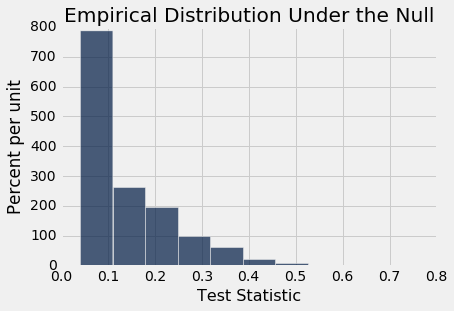

In [18]:
permutation_test_means(bta, 'Result', 'Group', 20000)

The empirical P-value is very small (the study reports a P-value of 0.009, which is consistent with our calculation), and thus the evidence points to the alternative: the underlying treatment and control distributions are different.

This is evidence that the treatment *causes* the difference, because the randomization ensures that there is no confounding variable that could affect the conclusion.

If the treatment had not been randomly assigned, our test would still point toward an *association* between the treatment and back pain outcomes among our 31 patients.  But beware: without randomization, this association would not imply that the treatment caused a change in back pain outcomes.  For example, if the patients themselves had chosen whether to administer the treatment, perhaps the patients experiencing more pain would be more likely to choose the treatment *and* more likely to experience some reduction in pain even without medication.  Pre-existing pain would then be a *confounding factor* in the analysis.

### A Confidence Interval for the Effect ###
As we noted in the previous section, it's a little unsatisfactory to simply conclude that the treatment does something. We're left wanting to know what it does.

So instead of performing a yes/no test of hypotheses about the two underlying distributions, let's simply estimate the difference between their means. Specifically, we are looking at the mean of all 31 control outcomes minus the mean of all 31 treatment outcomes. That's the unknown parameter. It is unknown because we only have 16 of the control values and 15 of the treatment values.

In our sample, the difference between the means is -47.5%. The control group had a mean of 12.5% whereas the treatment group had a mean of 60%. The negative sign of the difference says that the treatment group did better.

In [21]:
group_means = bta.group('Group', np.mean)
group_means

Group,Result mean
Control,0.125
Treatment,0.6


In [22]:
group_means.column(1).item(0) - group_means.column(1).item(1)

-0.475

But this is just the result in one sample; the sample could have come out differently. So we will replicate the sample using the bootstrap, and recompute the difference. That's exactly what we did in the previous section.

In [23]:
def bootstrap_ci_means(table, variable, classes, repetitions):
    
    """Bootstrap approximate 95% confidence interval
    for the difference between the means of the two classes
    in the population"""
    
    t = table.select(variable, classes)
    
    mean_diffs = make_array()
    for i in np.arange(repetitions):
        bootstrap_sample = t.sample()
        m_tbl = bootstrap_sample.group(classes, np.mean)
        new_stat = m_tbl.column(1).item(0) - m_tbl.column(1).item(1)
        mean_diffs = np.append(mean_diffs, new_stat)
        
    left = percentile(2.5, mean_diffs)
    right = percentile(97.5, mean_diffs)
    
    # Find the observed test statistic
    means_table = t.group(classes, np.mean) 
    obs_stat = means_table.column(1).item(0) - means_table.column(1).item(1)
    
    Table().with_column('Difference Between Means', mean_diffs).hist(bins=20)
    plots.plot(make_array(left, right), make_array(0, 0), color='yellow', lw=8)
    print('Observed difference between means:', obs_stat)
    print('Approximate 95% CI for the difference between means:')
    print(left, 'to', right)

Observed difference between means: -0.475
Approximate 95% CI for the difference between means:
-0.759090909091 to -0.162393162393


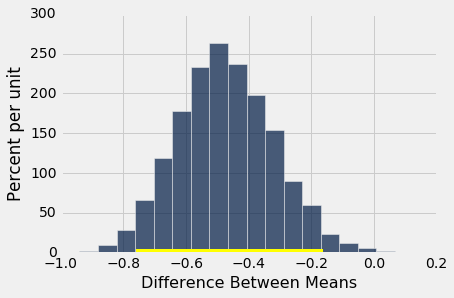

In [24]:
bootstrap_ci_means(bta, 'Result', 'Group', 20000)

An approximate 95% confidence interval for the difference between the means of the underlying distributions goes from about -80% to -20%. In other words, the treatment group did better by about 20% to 80%.

Notice the widely varying estimate. That's because the sample size is only about 15 in each group. While the methods work for such numbers without further assumptions, the results aren't very precise.

### A Meta-Analysis ###

While the RCT does provide evidence that the botulinum toxin A treatment helped patients, a study of 31 patients isn't enough to establish the effectiveness of a medical treatment. This is not just because of the small sample size.  Our results in this section are valid for the 31 patients in the study, but we are really interested in the population of *all possible patients*.  If the 31 patients were a random sample from *that* larger population, our confidence interval would be valid for that population.  But they were not a random sample.

In 2011, a group of researchers performed a [meta-analysis](https://www.ncbi.nlm.nih.gov/pubmed/21249702) of the studies on the treatment. That is, they identified all the available studies of such treatments for low-back pain and summarized the collated results. 

There were several studies but not many could be included in a scientifically sound manner: "We excluded evidence from nineteen studies due to non-randomisation, incomplete or unpublished data." Only three randomized controlled trials remained, one of which is the one we have studied in this section. The meta-analysis gave it the highest assessment among all the studies (LBP stands for low-back pain): "We identified three studies that investigated the merits of BoNT for LBP, but only one had a low risk of bias and evaluated patients with non-specific LBP (N = 31)." 

Putting it all together, the meta-analysis concluded, "There is low quality evidence that BoNT injections improved pain, function, or both better than saline injections and very low quality evidence that they were better than acupuncture or steroid injections. ...  Further research is very likely to have an important impact on the estimate of effect and our confidence in it. Future trials should standardize patient populations, treatment protocols and comparison groups, enlist more participants and include long-term outcomes, cost-benefit analysis and clinical relevance of findings."

It takes a lot of careful work to establish that a medical treatment has a beneficial effect. Knowing how to analyze randomized controlled trials is a crucial part of this work. Now that you know how to do that, you are well positioned to help medical and other professions establish cause-and-effect relations.